Here, we provide implementation of NUTS taken from: https://docs.pymc.io/notebooks/GP-Latent.html

However, it is important to note that this code was implemented in Google Colab to aid in the run time

In [21]:
import sys

import pymc3 as pm
import theano.tensor as tt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Here, we illustrate what the data looks like as well as the true underlying functions over the set of data points. 

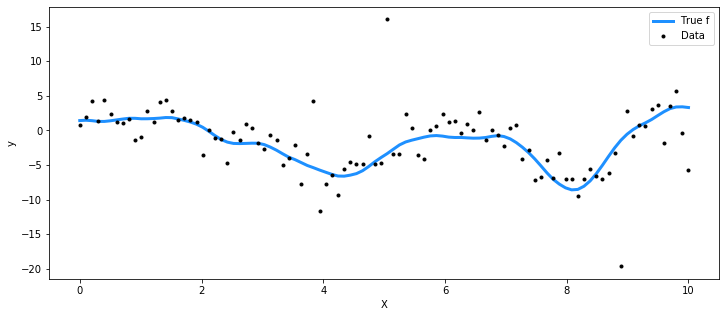

In [16]:
# set the seed
np.random.seed(1)

n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
σ_true = 2.0
ν_true = 3.0
y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

Here, we sample with the aid of a NUTS to approximate the posterior distribution of the data:

This code here, for some reason runs extremely poorly on my personal machine and hence Google Colab was made use of. 

In [19]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0/σ, nu=ν, observed=y)

    trace = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ν, σ, f_rotated_, η, ℓ]
  0%|                                                                              | 2/1500 [00:53<15:00:44, 36.08s/it]


SystemError: <class 'range'> returned a result with an error set
Apply node that caused the error: Elemwise{Composite{((i0 * i1) + i2)}}(Elemwise{mul,no_inplace}.0, Elemwise{sqr,no_inplace}.0, TensorConstant{[[1.e-06 0..0 1.e-06]]})
Toposort index: 66
Inputs types: [TensorType(float64, matrix), TensorType(float64, (True, True)), TensorType(float64, matrix)]
Inputs shapes: [(100, 100), (1, 1), (100, 100)]
Inputs strides: [(800, 8), (8, 8), (800, 8)]
Inputs values: ['not shown', array([[0.27623165]]), 'not shown']
Outputs clients: [[Cholesky{lower=True, destructive=False, on_error='raise'}(Elemwise{Composite{((i0 * i1) + i2)}}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
:
lines = [
    ("η",  {}, η_true),
    ("σ", {}, σ_true),
    ("ℓ", {}, ℓ_true),
    ("ν", {}, ν_true),
]
pm.traceplot(trace, lines=lines, var_names=["η", "σ", "ℓ", "ν"]);

The results are then plotted here:

In [ ]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, trace["f"], X);

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

The above results approximate only over the region which the data is defined on. However, we would like to be able to make further predictions on what the trends might look at a later stage:

In [ ]:
# 200 new values from x=0 to x=15
n_new = 200
X_new = np.linspace(0, 15, n_new)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)

In [ ]:
# plot the results

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new);
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Conditional distribution of f_*, given f"); plt.legend();